# Deep Learning: Coding Assignment 2



# Hello everyone :
Welcome to the second assignment for your Deep Learning course. Our objective in this exercise is to look into overfitting strategies in order to get the highest accuracy on test data. I hope you can find a better appreciation and deepen your understanding of the subject matter.

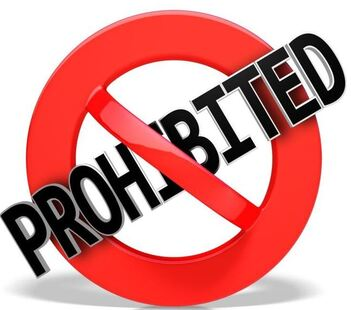

1. Please do not replica your assignments. ❌
2. On the one hand, Your codes ought to include explanations. On the other hand, You do not demand to consider any separate file for your report.   ✅
* **There is no obligation that your answer includes many details. Your response can be concise but should be accurate and to the point.**
   
* **Either Persian or English is acceptable for your report.** Nonetheless, if you choose to write Persian in Markdown, please make sure it's legible before submitting your notebook.

# Prerequisites:
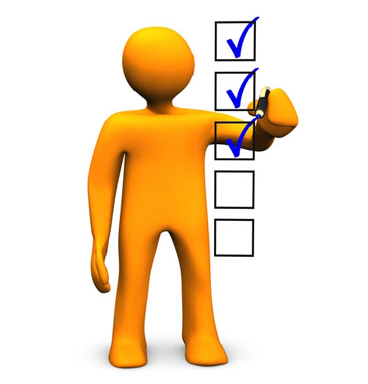

We anticipate that you will adhere to the following:
1. You are not allowed to use convolutional layers. ❌
2. It is not permitted to use automated hyperparameter tuning tools. ❌

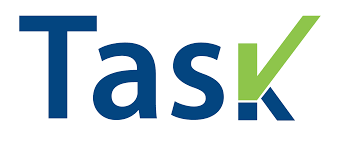

To complete this activity, do the following:
1. Data normalize
2. Separate data to train, validation and test
3. Use GD, GD with momentum, and Adam as activation functions to train the network.
4. For the train and validation data, draw the error and accuracy graph during the training phase.
5. To assess network performance on test data, use benchmarks f1 score, precision, and recall for each classes.
6. Add dropout to your code by changing it. Next, train the model using the proper optimizer function. Create data and accuracy and loss graphs, then compare and evaluate the outcomes.
7. Use batch normalization in your model and then check the results again.
8. To train your network, apply at least two strategies of learning rate decay.
9. Add the L2 regularization to your model
10. After retraining your network and utilizing at least two data augmentation techniques, report the outcomes.




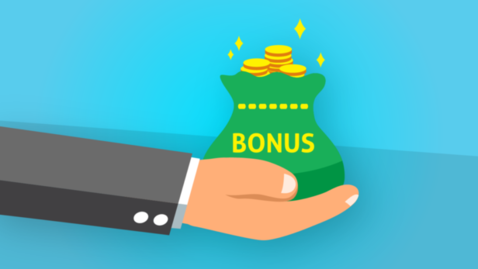

#**Bonus**
The model with the highest accuracy on the test receives an extra point.

# $\color{green}{\text{About dataset:}}$
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


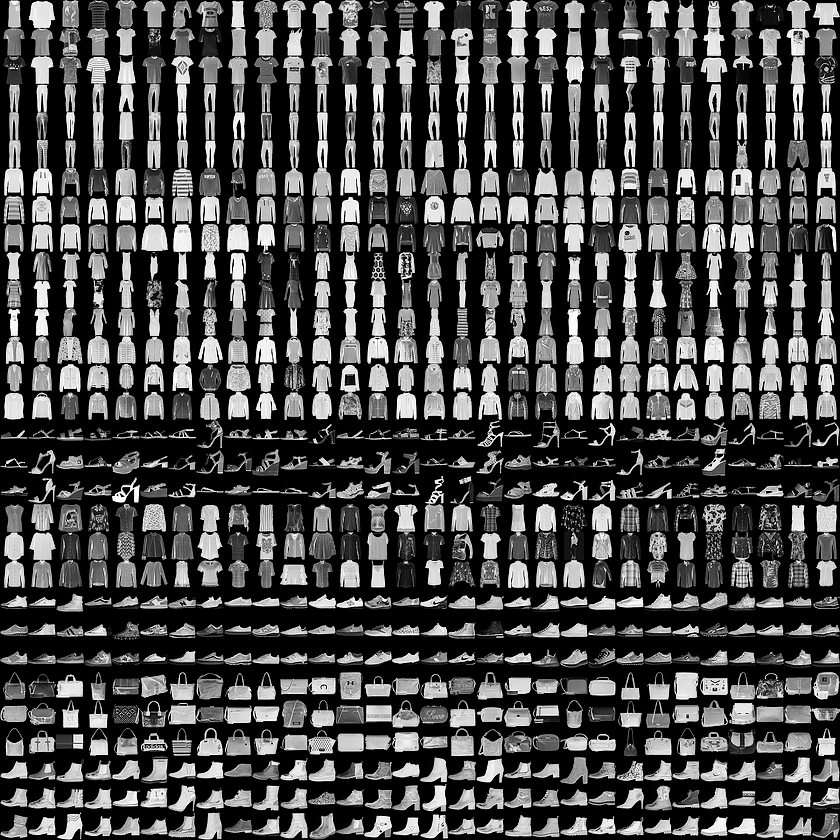

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torchvision import datasets, transforms

In [2]:
#choosing device running model
my_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', my_gpu)
print('GPU Model:', torch.cuda.get_device_name(my_gpu))

Device: cuda
GPU Model: GeForce GTX 1650


# Step 1

- The transforms.ToTensor() transformation in PyTorch is used to convert an input image, which could be in various formats like PIL Image or NumPy array, into a PyTorch tensor. It essentially converts the image data into a format that PyTorch can work with, allowing you to perform operations like training neural networks.
- The transforms.Normalize((mean,), (std,)) transformation in PyTorch is used to normalize the pixel values of an image. This normalization is a common preprocessing step in deep learning to ensure that the input data has a mean and standard deviation that facilitates better training.
- The reason for using 0.5 as both mean and standard deviation is to scale the pixel values to be in the range of -1 to 1. The original pixel values in Fashion-MNIST are in the range of 0 to 1, so subtracting 0.5 shifts the range to -0.5 to 0.5, and dividing by 0.5 scales it to -1 to 1.

In [3]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [4]:
# Download and load the full dataset and transform it
full_dataset = datasets.FashionMNIST("./data/", download = True, train = True, transform = transform)

# Step 2

In [5]:
# Define the sizes of your training, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [6]:
# Use random_split to create the training, validation, and test datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

- The purpose of train_loader is to efficiently load and organize the training data in batches
so that it can be fed into the training process of the model. It handles tasks such as shuffling
the data, dividing it into batches, and moving data to the GPU. Each batch is a subset of the whole
dataset that the model's parameters are updated with this subset during each iteration of the
training process.

In [7]:
# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False, num_workers = 4, pin_memory = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 4, pin_memory = True)

# Step 3 & Step 4

In [8]:
# Define dimension of the images
img, label = train_dataset[0]

height = img.shape[1]
width = img.shape[2]


# NN layers
input_size = height * width

fc1_output_size = 256
fc2_output_size = 128
fc3_output_size = 64
fc4_output_size = 10


num_classes = 10 # There are 10 classes that we can recognize


In [9]:
# Design your neural network architecture
class MySimpleNN(nn.Module):
    def __init__(self):
        super(MySimpleNN, self).__init__()

        self.fc1 = nn.Linear(input_size, fc1_output_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(fc2_output_size, fc3_output_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(fc3_output_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)

        return x

In [10]:
# Choose loss function
criterion = nn.CrossEntropyLoss()

In [11]:
# Define a train function for the training phase
def trainNN(model, optimizer, criterion, train_loader, val_loader, num_epochs = 25):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Set the model in training mode
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            # Load data to the GPU
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Clear the gradients of all model parameters
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the model's parameters using the optimizer method
            optimizer.step()

            # Sum of all losses
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Logging for training
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print the training loss and accuracy for each epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")

        # Set the model in evaluation mode
        model.eval()
        total_loss_val = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                # Load data to the GPU
                inputs_val = inputs_val.cuda()
                labels_val = labels_val.cuda()

                # Forward pass
                outputs_val = model(inputs_val)

                # Compute loss
                loss_val = criterion(outputs_val, labels_val)

                # Sum of all validation losses
                total_loss_val += loss_val.item()

                # Calculate validation accuracy
                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        val_loss = total_loss_val / len(val_loader)
        val_accuracy = correct_val / total_val

        # Logging for validation
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print the validation loss and accuracy for each epoch
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [12]:
def plottt(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

#### GD

In [12]:
# Initialize the model
model_gd = MySimpleNN().cuda()

# Choose Optimizer
optimizer_gd = optim.SGD(model_gd.parameters(), lr = 0.01)

In [13]:
# Train the model
print("Training with Gradient Descent (GD)")
train_losses_gd, train_accuracies_gd, val_losses_gd, val_accuracies_gd = trainNN(
    model_gd, optimizer_gd, criterion, train_loader, val_loader
)

Training with Gradient Descent (GD)


Epoch 1/25, Train Loss: 1.4673, Train Acc: 0.4982
Validation Loss: 0.8308, Validation Acc: 0.6895
Epoch 2/25, Train Loss: 0.6881, Train Acc: 0.7473
Validation Loss: 0.6382, Validation Acc: 0.7560
Epoch 3/25, Train Loss: 0.5725, Train Acc: 0.7904
Validation Loss: 0.5835, Validation Acc: 0.7943
Epoch 4/25, Train Loss: 0.5135, Train Acc: 0.8145
Validation Loss: 0.5065, Validation Acc: 0.8218
Epoch 5/25, Train Loss: 0.4751, Train Acc: 0.8281
Validation Loss: 0.5001, Validation Acc: 0.8200
Epoch 6/25, Train Loss: 0.4502, Train Acc: 0.8358
Validation Loss: 0.4433, Validation Acc: 0.8447
Epoch 7/25, Train Loss: 0.4285, Train Acc: 0.8459
Validation Loss: 0.4377, Validation Acc: 0.8473
Epoch 8/25, Train Loss: 0.4119, Train Acc: 0.8521
Validation Loss: 0.4198, Validation Acc: 0.8532
Epoch 9/25, Train Loss: 0.3973, Train Acc: 0.8560
Validation Loss: 0.4102, Validation Acc: 0.8540
Epoch 10/25, Train Loss: 0.3856, Train Acc: 0.8607
Validation Loss: 0.3952, Validation Acc: 0.8597
Epoch 11/25, Train 

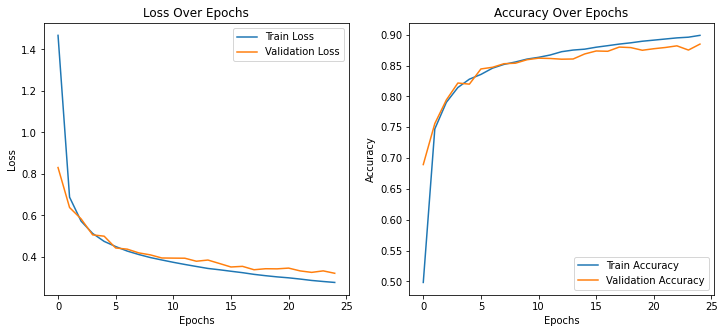

In [14]:
plottt(train_losses_gd, val_losses_gd, train_accuracies_gd, val_accuracies_gd)

#### GD with momentum

In [15]:
# Initialize the model
model_momentum = MySimpleNN().cuda()

# Choose Optimizer
optimizer_momentum = optim.SGD(model_momentum.parameters(), lr = 0.01, momentum = 0.9)

In [16]:
# Train the model
print("Training with momentum (GD with momentum)")
train_losses_momentum, train_accuracies_momentum, val_losses_momentum, val_accuracies_momentum = trainNN(
    model_momentum, optimizer_momentum, criterion, train_loader, val_loader
)

Training with momentum (GD with momentum)
Epoch 1/25, Train Loss: 0.6964, Train Acc: 0.7465
Validation Loss: 0.4587, Validation Acc: 0.8373
Epoch 2/25, Train Loss: 0.4190, Train Acc: 0.8455
Validation Loss: 0.4180, Validation Acc: 0.8475
Epoch 3/25, Train Loss: 0.3755, Train Acc: 0.8623
Validation Loss: 0.3666, Validation Acc: 0.8700
Epoch 4/25, Train Loss: 0.3417, Train Acc: 0.8760
Validation Loss: 0.3663, Validation Acc: 0.8688
Epoch 5/25, Train Loss: 0.3200, Train Acc: 0.8822
Validation Loss: 0.3459, Validation Acc: 0.8743
Epoch 6/25, Train Loss: 0.3058, Train Acc: 0.8869
Validation Loss: 0.3504, Validation Acc: 0.8750
Epoch 7/25, Train Loss: 0.2883, Train Acc: 0.8925
Validation Loss: 0.3199, Validation Acc: 0.8822
Epoch 8/25, Train Loss: 0.2749, Train Acc: 0.8986
Validation Loss: 0.3444, Validation Acc: 0.8737
Epoch 9/25, Train Loss: 0.2614, Train Acc: 0.9012
Validation Loss: 0.3178, Validation Acc: 0.8857
Epoch 10/25, Train Loss: 0.2527, Train Acc: 0.9051
Validation Loss: 0.3154, 

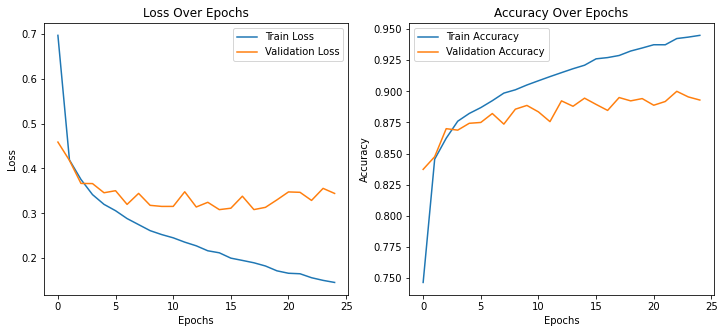

In [17]:
plottt(train_losses_momentum, val_losses_momentum, train_accuracies_momentum, val_accuracies_momentum)

#### Adam

In [18]:
# Initialize the model
model_adam = MySimpleNN().cuda()

# Choose Optimizer
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

In [19]:
# Train the model
print("Training with Adam")
train_losses_adam, train_accuracies_adam, val_losses_adam, val_accuracies_adam = trainNN(
    model_adam, optimizer_adam, criterion, train_loader, val_loader
)

Training with Adam
Epoch 1/25, Train Loss: 0.5384, Train Acc: 0.8002
Validation Loss: 0.4216, Validation Acc: 0.8465
Epoch 2/25, Train Loss: 0.3863, Train Acc: 0.8567
Validation Loss: 0.3796, Validation Acc: 0.8618
Epoch 3/25, Train Loss: 0.3470, Train Acc: 0.8716
Validation Loss: 0.3711, Validation Acc: 0.8672
Epoch 4/25, Train Loss: 0.3213, Train Acc: 0.8809
Validation Loss: 0.3731, Validation Acc: 0.8607
Epoch 5/25, Train Loss: 0.3006, Train Acc: 0.8870
Validation Loss: 0.3280, Validation Acc: 0.8797
Epoch 6/25, Train Loss: 0.2838, Train Acc: 0.8946
Validation Loss: 0.3272, Validation Acc: 0.8788
Epoch 7/25, Train Loss: 0.2675, Train Acc: 0.8994
Validation Loss: 0.3138, Validation Acc: 0.8837
Epoch 8/25, Train Loss: 0.2570, Train Acc: 0.9042
Validation Loss: 0.3120, Validation Acc: 0.8837
Epoch 9/25, Train Loss: 0.2431, Train Acc: 0.9087
Validation Loss: 0.3322, Validation Acc: 0.8788
Epoch 10/25, Train Loss: 0.2335, Train Acc: 0.9116
Validation Loss: 0.3343, Validation Acc: 0.8832


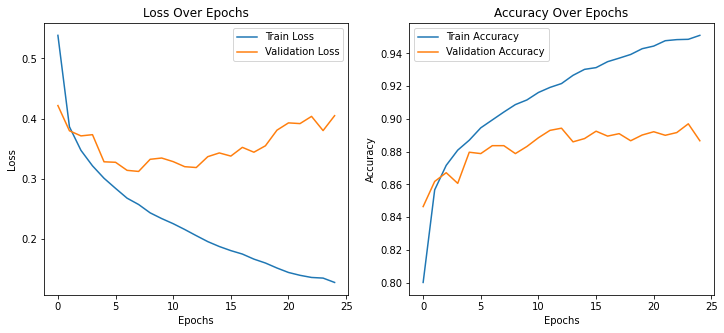

In [20]:
plottt(train_losses_adam, val_losses_adam, train_accuracies_adam, val_accuracies_adam)

# Step 5

In [13]:
def test(model, test_loader, num_classes = 10):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to CUDA
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)


            # The following is done to make it compatible with scikit-learn functions, which typically expect data in
            # the form of NumPy arrays

            # The extend method is used to add the elements of the NumPy array (ground truth labels for the
            # current batch) to the end of the all_labels list
            all_labels.extend(labels.cpu().numpy())

            # The extend method is used to add the elements of the NumPy array (predicted labels for the
            # current batch) to the end of the all_predictions list.
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate precision, recall, F1 score, and accuracy for each class
    # generate a text report showing the main classification metrics (precision, recall, F1 score) for each class
    report = classification_report(all_labels, all_predictions, target_names = [f"Class {i}" for i in range(num_classes)])
    print("Classification Report:")
    print(report)

In [22]:
test(model_gd, test_loader)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.85      0.84       605
     Class 1       0.99      0.96      0.98       605
     Class 2       0.78      0.82      0.80       562
     Class 3       0.84      0.92      0.88       598
     Class 4       0.80      0.79      0.80       580
     Class 5       0.98      0.90      0.94       583
     Class 6       0.77      0.67      0.72       632
     Class 7       0.89      0.98      0.93       636
     Class 8       0.97      0.97      0.97       598
     Class 9       0.96      0.94      0.95       601

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



In [23]:
test(model_momentum, test_loader)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.86      0.85       605
     Class 1       0.99      0.97      0.98       605
     Class 2       0.85      0.75      0.80       562
     Class 3       0.91      0.89      0.90       598
     Class 4       0.74      0.88      0.81       580
     Class 5       0.96      0.95      0.95       583
     Class 6       0.76      0.70      0.73       632
     Class 7       0.95      0.95      0.95       636
     Class 8       0.97      0.98      0.98       598
     Class 9       0.96      0.97      0.96       601

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



In [24]:
test(model_adam, test_loader)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.75      0.81       605
     Class 1       0.99      0.97      0.98       605
     Class 2       0.83      0.76      0.79       562
     Class 3       0.87      0.91      0.89       598
     Class 4       0.83      0.80      0.81       580
     Class 5       0.92      0.96      0.94       583
     Class 6       0.66      0.81      0.73       632
     Class 7       0.92      0.93      0.93       636
     Class 8       0.97      0.98      0.97       598
     Class 9       0.98      0.92      0.95       601

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



# Step 6

In [25]:
# For Fashion-MNIST, which is a dataset of clothing images, using Adam is a common and often
# effective choice. It tends to handle a variety of datasets and architectures well, offering
# a good balance between fast convergence and generalization

# So, I'm gonna go with Adam optimizer

# Design your neural network architecture
class MyNNWithDropout(nn.Module):
    # Constructor of the class
    def __init__(self):
        # Call the constructor of the parent class nn.Module
        super(MyNNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_output_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(fc2_output_size, fc3_output_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(fc3_output_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

In [26]:
# Initialize the model
model_adam_dropout = MyNNWithDropout().cuda()

# Choose Optimizer
optimizer_adam_dropout = optim.Adam(model_adam_dropout.parameters(), lr = 0.001)

In [27]:
# Train the model
print("Training with Adam")
train_losses_adam_dropout, train_accuracies_adam_dropout, val_losses_adam_dropout, val_accuracies_adam_dropout = trainNN(
    model_adam_dropout, optimizer_adam_dropout, criterion, train_loader, val_loader
)

Training with Adam


Epoch 1/25, Train Loss: 0.6284, Train Acc: 0.7706
Validation Loss: 0.4431, Validation Acc: 0.8402
Epoch 2/25, Train Loss: 0.4523, Train Acc: 0.8384
Validation Loss: 0.3938, Validation Acc: 0.8610
Epoch 3/25, Train Loss: 0.4053, Train Acc: 0.8554
Validation Loss: 0.3776, Validation Acc: 0.8653
Epoch 4/25, Train Loss: 0.3853, Train Acc: 0.8620
Validation Loss: 0.3469, Validation Acc: 0.8705
Epoch 5/25, Train Loss: 0.3672, Train Acc: 0.8673
Validation Loss: 0.3638, Validation Acc: 0.8707
Epoch 6/25, Train Loss: 0.3517, Train Acc: 0.8730
Validation Loss: 0.3863, Validation Acc: 0.8563
Epoch 7/25, Train Loss: 0.3412, Train Acc: 0.8784
Validation Loss: 0.3439, Validation Acc: 0.8747
Epoch 8/25, Train Loss: 0.3247, Train Acc: 0.8818
Validation Loss: 0.3331, Validation Acc: 0.8792
Epoch 9/25, Train Loss: 0.3162, Train Acc: 0.8857
Validation Loss: 0.3167, Validation Acc: 0.8817
Epoch 10/25, Train Loss: 0.3095, Train Acc: 0.8861
Validation Loss: 0.3183, Validation Acc: 0.8917
Epoch 11/25, Train 

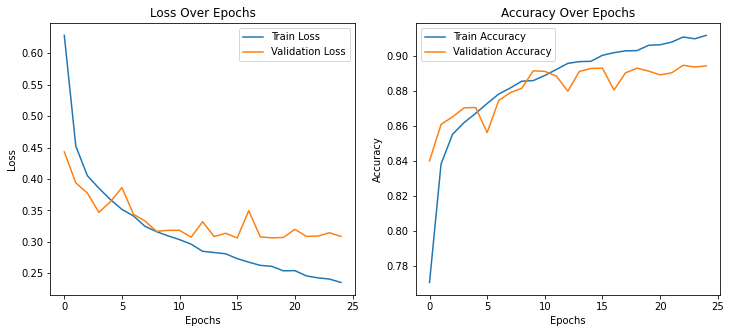

In [28]:
plottt(train_losses_adam_dropout, val_losses_adam_dropout, train_accuracies_adam_dropout, val_accuracies_adam_dropout)

- Dropout is typically applied during the training phase, not during validation or testing. During training, dropout randomly sets a fraction of the units to zero, which helps prevent overfitting. However, during validation, all units are active. This means that the model might be more conservative during training due to dropout, leading to slightly lower accuracy. Thus, it is possible for the accuracy of validation to be more than accuracy of training

In [29]:
test(model_adam_dropout, test_loader)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.87      0.84       605
     Class 1       0.98      0.98      0.98       605
     Class 2       0.82      0.78      0.80       562
     Class 3       0.88      0.90      0.89       598
     Class 4       0.80      0.83      0.82       580
     Class 5       0.97      0.94      0.96       583
     Class 6       0.77      0.68      0.72       632
     Class 7       0.93      0.96      0.95       636
     Class 8       0.95      0.98      0.97       598
     Class 9       0.96      0.95      0.95       601

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



- The impact of dropout on the model's performance can vary depending on the dataset, model architecture, and other factors. Dropout is a regularization technique that is intended to prevent overfitting by randomly dropping out (setting to zero) a fraction of the neurons during training.
- Because my prior model was not overfitted and performed well on the test set without dropout, it's possible that the dataset doesn't require the extra regularization provided by dropout. Dropout is more beneficial when dealing with complex models or datasets with a relatively small amount of training data.

# Step 7

In [14]:
# For Fashion-MNIST, which is a dataset of clothing images, using Adam is a common and often
# effective choice. It tends to handle a variety of datasets and architectures well, offering
# a good balance between fast convergence and generalization

# So, I'm gonna go with Adam optimizer

# Design your neural network architecture
class MyNNWithDropoutBatchNormalization(nn.Module):
    # Constructor of the class
    def __init__(self):
        # Call the constructor of the parent class nn.Module
        super(MyNNWithDropoutBatchNormalization, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_output_size)
        self.bn1 = nn.BatchNorm1d(fc1_output_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
        self.bn2 = nn.BatchNorm1d(fc2_output_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(fc2_output_size, fc3_output_size)
        self.bn3 = nn.BatchNorm1d(fc3_output_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(fc3_output_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

In [14]:
# Initialize the model
model_adam_dropout_batchnorm = MyNNWithDropoutBatchNormalization().cuda()

# Choose Optimizer
optimizer_adam_dropout_batchnorm = optim.Adam(model_adam_dropout_batchnorm.parameters(), lr = 0.001)

In [15]:
# Train the model
print("Training with Adam")
train_losses_adam_dropout_batchnorm, train_accuracies_adam_dropout_batchnorm, val_losses_adam_dropout_batchnorm, val_accuracies_adam_dropout_batchnorm = trainNN(
    model_adam_dropout_batchnorm, optimizer_adam_dropout_batchnorm, criterion, train_loader, val_loader
)

Training with Adam
Epoch 1/25, Train Loss: 0.5849, Train Acc: 0.8070
Validation Loss: 0.4012, Validation Acc: 0.8517
Epoch 2/25, Train Loss: 0.4185, Train Acc: 0.8503
Validation Loss: 0.3347, Validation Acc: 0.8788
Epoch 3/25, Train Loss: 0.3841, Train Acc: 0.8614
Validation Loss: 0.3242, Validation Acc: 0.8832
Epoch 4/25, Train Loss: 0.3579, Train Acc: 0.8710
Validation Loss: 0.3145, Validation Acc: 0.8807
Epoch 5/25, Train Loss: 0.3376, Train Acc: 0.8776
Validation Loss: 0.3016, Validation Acc: 0.8872
Epoch 6/25, Train Loss: 0.3212, Train Acc: 0.8833
Validation Loss: 0.2948, Validation Acc: 0.8943
Epoch 7/25, Train Loss: 0.3118, Train Acc: 0.8854
Validation Loss: 0.2897, Validation Acc: 0.8942
Epoch 8/25, Train Loss: 0.3004, Train Acc: 0.8891
Validation Loss: 0.2868, Validation Acc: 0.8952
Epoch 9/25, Train Loss: 0.2921, Train Acc: 0.8938
Validation Loss: 0.2823, Validation Acc: 0.8963
Epoch 10/25, Train Loss: 0.2798, Train Acc: 0.8974
Validation Loss: 0.2857, Validation Acc: 0.8945


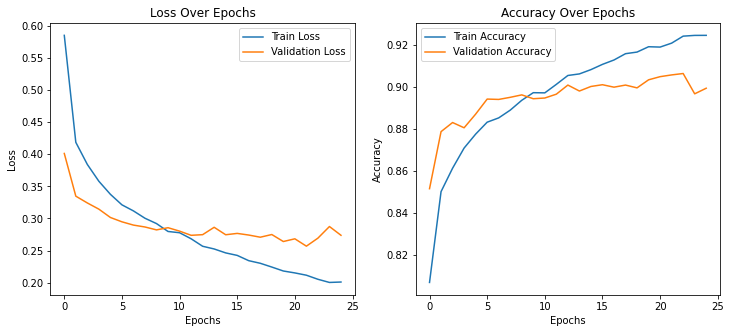

In [18]:
plottt(train_losses_adam_dropout_batchnorm, val_losses_adam_dropout_batchnorm, train_accuracies_adam_dropout_batchnorm, val_accuracies_adam_dropout_batchnorm)

In [19]:
test(model_adam_dropout_batchnorm, test_loader)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.87      0.85       590
     Class 1       0.99      0.98      0.99       568
     Class 2       0.85      0.82      0.83       609
     Class 3       0.91      0.94      0.93       570
     Class 4       0.80      0.86      0.83       612
     Class 5       0.97      0.95      0.96       645
     Class 6       0.78      0.70      0.74       580
     Class 7       0.92      0.97      0.94       611
     Class 8       0.98      0.97      0.98       618
     Class 9       0.97      0.95      0.96       597

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



# Step 8

In [21]:
# Define a train function for the training phase
def trainNNWithDecay(model, optimizer, criterion, train_loader, val_loader, num_epochs = 25, lr_decay = None, gamma = None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Set up learning rate scheduler
    if lr_decay == 'step':
        scheduler = StepLR(optimizer, step_size = 5, gamma = gamma)
    elif lr_decay == 'exp':
        scheduler = ExponentialLR(optimizer, gamma = gamma)
    else:
        scheduler = None

    for epoch in range(num_epochs):
        # Set the model in training mode
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            # Load data to the GPU
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Clear the gradients of all model parameters
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the model's parameters using the optimizer method
            optimizer.step()

            # Sum of all losses
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step()

        # Logging for training
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print the training loss and accuracy for each epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")

        # Set the model in evaluation mode
        model.eval()
        total_loss_val = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                # Load data to the GPU
                inputs_val = inputs_val.cuda()
                labels_val = labels_val.cuda()

                # Forward pass
                outputs_val = model(inputs_val)

                # Compute loss
                loss_val = criterion(outputs_val, labels_val)

                # Sum of all validation losses
                total_loss_val += loss_val.item()

                # Calculate validation accuracy
                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        val_loss = total_loss_val / len(val_loader)
        val_accuracy = correct_val / total_val

        # Logging for validation
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print the validation loss and accuracy for each epoch
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [22]:
# First strategy: 
# Initialize the model
model_adam_dropout_batchnorm_lrdecay_step = MyNNWithDropoutBatchNormalization().cuda()

# Choose Optimizer
optimizer_adam_dropout_batchnorm_lrdecay_step = optim.Adam(model_adam_dropout_batchnorm_lrdecay_step.parameters(), lr = 0.001)

In [23]:
train_losses_adam_dropout_batchnorm_lrdecay_step, train_accuracies_adam_dropout_batchnorm_lrdecay_step, val_losses_adam_dropout_batchnorm_lrdecay_step, val_accuracies_adam_dropout_batchnorm_lrdecay_step = trainNNWithDecay(
    model_adam_dropout_batchnorm_lrdecay_step, optimizer_adam_dropout_batchnorm_lrdecay_step, criterion, train_loader, val_loader, num_epochs = 25, lr_decay = 'step', gamma = 0.1
)

Epoch 1/25, Train Loss: 0.5976, Train Acc: 0.8033
Validation Loss: 0.3794, Validation Acc: 0.8617
Epoch 2/25, Train Loss: 0.4227, Train Acc: 0.8514
Validation Loss: 0.3423, Validation Acc: 0.8760
Epoch 3/25, Train Loss: 0.3822, Train Acc: 0.8628
Validation Loss: 0.3412, Validation Acc: 0.8750
Epoch 4/25, Train Loss: 0.3601, Train Acc: 0.8699
Validation Loss: 0.3153, Validation Acc: 0.8840
Epoch 5/25, Train Loss: 0.3422, Train Acc: 0.8754
Validation Loss: 0.3043, Validation Acc: 0.8878
Epoch 6/25, Train Loss: 0.2947, Train Acc: 0.8949
Validation Loss: 0.2741, Validation Acc: 0.8982
Epoch 7/25, Train Loss: 0.2807, Train Acc: 0.8982
Validation Loss: 0.2735, Validation Acc: 0.8982
Epoch 8/25, Train Loss: 0.2748, Train Acc: 0.9012
Validation Loss: 0.2732, Validation Acc: 0.8987
Epoch 9/25, Train Loss: 0.2677, Train Acc: 0.9020
Validation Loss: 0.2706, Validation Acc: 0.8983
Epoch 10/25, Train Loss: 0.2656, Train Acc: 0.9031
Validation Loss: 0.2706, Validation Acc: 0.8970
Epoch 11/25, Train 

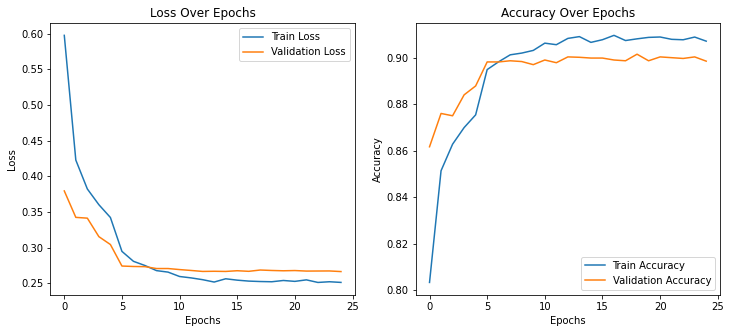

In [24]:
plottt(train_losses_adam_dropout_batchnorm_lrdecay_step, val_losses_adam_dropout_batchnorm_lrdecay_step, train_accuracies_adam_dropout_batchnorm_lrdecay_step, val_accuracies_adam_dropout_batchnorm_lrdecay_step)

In [25]:
test(model_adam_dropout_batchnorm_lrdecay_step, test_loader)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.85      0.85      0.85       603
     Class 1       0.98      0.97      0.98       625
     Class 2       0.83      0.83      0.83       600
     Class 3       0.90      0.92      0.91       622
     Class 4       0.80      0.84      0.82       612
     Class 5       0.97      0.96      0.97       599
     Class 6       0.76      0.71      0.73       606
     Class 7       0.95      0.96      0.95       587
     Class 8       0.97      0.96      0.97       560
     Class 9       0.97      0.97      0.97       586

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



In [26]:
# First strategy: 
# Initialize the model
model_adam_dropout_batchnorm_lrdecay_exp = MyNNWithDropoutBatchNormalization().cuda()

# Choose Optimizer
optimizer_adam_dropout_batchnorm_lrdecay_exp = optim.Adam(model_adam_dropout_batchnorm_lrdecay_exp.parameters(), lr = 0.001)

In [27]:
train_losses_adam_dropout_batchnorm_lrdecay_exp, train_accuracies_adam_dropout_batchnorm_lrdecay_exp, val_losses_adam_dropout_batchnorm_lrdecay_exp, val_accuracies_adam_dropout_batchnorm_lrdecay_exp = trainNNWithDecay(
    model_adam_dropout_batchnorm_lrdecay_exp, optimizer_adam_dropout_batchnorm_lrdecay_exp, criterion, train_loader, val_loader, num_epochs = 25, lr_decay = 'exp', gamma = 0.1
)

Epoch 1/25, Train Loss: 0.5965, Train Acc: 0.8037
Validation Loss: 0.3927, Validation Acc: 0.8552
Epoch 2/25, Train Loss: 0.4020, Train Acc: 0.8578
Validation Loss: 0.3401, Validation Acc: 0.8738
Epoch 3/25, Train Loss: 0.3770, Train Acc: 0.8682
Validation Loss: 0.3366, Validation Acc: 0.8765
Epoch 4/25, Train Loss: 0.3791, Train Acc: 0.8659
Validation Loss: 0.3356, Validation Acc: 0.8765
Epoch 5/25, Train Loss: 0.3747, Train Acc: 0.8678
Validation Loss: 0.3365, Validation Acc: 0.8768
Epoch 6/25, Train Loss: 0.3739, Train Acc: 0.8684
Validation Loss: 0.3360, Validation Acc: 0.8768
Epoch 7/25, Train Loss: 0.3778, Train Acc: 0.8685
Validation Loss: 0.3351, Validation Acc: 0.8758
Epoch 8/25, Train Loss: 0.3756, Train Acc: 0.8681
Validation Loss: 0.3377, Validation Acc: 0.8773
Epoch 9/25, Train Loss: 0.3784, Train Acc: 0.8678
Validation Loss: 0.3351, Validation Acc: 0.8767
Epoch 10/25, Train Loss: 0.3762, Train Acc: 0.8688
Validation Loss: 0.3360, Validation Acc: 0.8767
Epoch 11/25, Train 

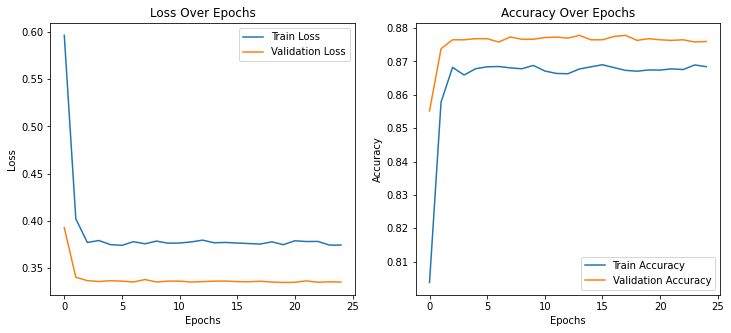

In [28]:
plottt(train_losses_adam_dropout_batchnorm_lrdecay_exp, val_losses_adam_dropout_batchnorm_lrdecay_exp, train_accuracies_adam_dropout_batchnorm_lrdecay_exp, val_accuracies_adam_dropout_batchnorm_lrdecay_exp)

In [29]:
test(model_adam_dropout_batchnorm_lrdecay_exp, test_loader)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.84      0.83       603
     Class 1       0.99      0.97      0.98       625
     Class 2       0.77      0.80      0.79       600
     Class 3       0.89      0.89      0.89       622
     Class 4       0.77      0.80      0.78       612
     Class 5       0.96      0.94      0.95       599
     Class 6       0.71      0.65      0.68       606
     Class 7       0.93      0.95      0.94       587
     Class 8       0.95      0.96      0.95       560
     Class 9       0.96      0.96      0.96       586

    accuracy                           0.87      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.87      0.87      0.87      6000



# Step 9

# Step 10

# $\color{green}{\text{Grades}}$:

Question Number  | Scores
-------------------|------------------
Step 1    | 3
Step 2    | 3
Step 3 | 22
Step 4 | 20
Step 5 | 27
Step 6 | 20
Step 7 | 20
Step 8 | 15
Step 9 | 20
Step 10 | 15